#Mount and imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Feb  4 12:17:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers==4.2.1
!pip install farasapy
!pip install pyarabic
!pip install sentencepiece
!git clone https://github.com/aub-mind/arabert
!git clone https://github.com/iR00i/JUST-Arabic-Propaganda.git

     |████████████████████████████████| 1.8 MB 7.9 MB/s 
     |████████████████████████████████| 2.9 MB 44.9 MB/s 
     |████████████████████████████████| 895 kB 21.0 MB/s 
     |████████████████████████████████| 126 kB 9.2 MB/s 
     |████████████████████████████████| 1.2 MB 8.1 MB/s 
Cloning into 'arabert'...
remote: Enumerating objects: 559, done.
remote: Counting objects: 100% (345/345), done.
remote: Compressing objects: 100% (247/247), done.
remote: Total 559 (delta 184), reused 246 (delta 92), pack-reused 214
Receiving objects: 100% (559/559), 9.16 MiB | 21.45 MiB/s, done.
Resolving deltas: 100% (307/307), done.
Cloning into 'JUST-Arabic-Propaganda'...
remote: Enumerating objects: 1627, done.
remote: Counting objects: 100% (1627/1627), done.
remote: Compressing objects: 100% (1487/1487), done.
remote: Total 1627 (delta 87), reused 1604 (delta 67), pack-reused 0
Receiving objects: 100% (1627/1627), 4.38 MiB | 20.98 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [ ]:
import pandas as pd
import numpy as np
import re

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from arabert.preprocess import ArabertPreprocessor
import transformers
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
import json
from pathlib import Path
from sklearn.metrics import confusion_matrix
%matplotlib inline

#Pandas Viewing presets

In [ ]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('display.max_rows', None)
# pd.options.display.max_colwidth = 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
pd.reset_option('^display.', silent=True)

# Notebook Utility

##Dataset class and functions

In [ ]:
class Dataset:
  """
  Class Dataset used to create an iterable version of the dataset with the
  ability to return the text tokenized upon indexing.

  An object of this class can be treated as a list object. Indexing with this 
  object (ex: dataset[idx] ) will return a dictionary. 

  len(obj) =
  """
  def __init__(self, text, target, tokenizer):
    self.text = text
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = config['MAX_LEN']

  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    text = str(self.text[item])
    text = " ".join(text.split())

    inputs = self.tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding='max_length',
        truncation='longest_first'
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs['token_type_ids']

    return {
        "ids": torch.tensor(ids, dtype=torch.long),
        "mask": torch.tensor(mask, dtype=torch.long),
        "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
        "targets": torch.tensor(self.target[item], dtype=torch.float),
    }

In [ ]:
def loss_fn(outputs, targets):
  """ 
  Loss function to claculate loss. Loss measure used is the Binary-Cross-
  Entropy.
  """
  return nn.BCEWithLogitsLoss()(outputs, targets)

def train_fn(data_loader, model, optimizer, device, scheduler):
  """
  Training function. Accepts a torch.dataLoader object, the model to be trained,
  the optimizer, the device to be trained on (ex: Cuda) and finally a scheduler
  for the optimizer.

  The dataLoader is used to iterate over the batches of the training data.
  Performs forward and backprop on the model and saves the weights.
  """
  model.train()

  for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
    ids = d["ids"]
    token_type_ids = d["token_type_ids"]
    mask = d["mask"]
    targets = d["targets"]

    ids = ids.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    targets = targets.to(device, dtype=torch.float)

    optimizer.zero_grad()
    outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)

    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    scheduler.step()

def eval_fn(data_loader, model, device):
  """
  Similar to the training function but the model is in evaluation mode (model 
  layers are frozen).

  Performs forward-prop on the model with the validation data.
  Returns the model predictions as well as the data gold labels.
  """
  model.eval()
  fin_targets = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
      ids = d["ids"]
      token_type_ids = d["token_type_ids"]
      mask = d["mask"]
      targets = d["targets"]

      ids = ids.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype=torch.long)
      mask = mask.to(device, dtype=torch.long)
      targets = targets.to(device, dtype=torch.float)

      outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
      fin_targets.extend(targets.cpu().detach().numpy().tolist())
      fin_outputs.extend(F.softmax(outputs, dim = 1).cpu().detach().numpy().tolist())
  return fin_outputs, fin_targets

##Preprocessing Code

In [ ]:
# """
# Old code.
# """

# def MapLabels(df):
#   """
#   Function to preprocess data.
#   Removes unwanted datasamples according to specific labels.
#   Creates a one-hot-encoded version of the labels. 
#   """
#   onehot_col = []
#   df.drop(df.loc[df['label']=='Repetition'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Bandwagon'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Straw_Men'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Whataboutism'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Reductio_ad_hitlerum'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Red_Herring'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Obfuscation,Intentional_Vagueness,Confusion'].index, inplace=True)
#   df.drop(df.loc[df['label']=='Thought-terminating_Cliches'].index, inplace=True)

#   map = {
#       'Slogans':0,
#       'Black-and-White_Fallacy':1,
#       'Loaded_Language':2,
#       'Flag-Waving':3,
#       'Name_Calling':4,
#       'Labeling':5,
#       'Causal_Oversimplification':6,
#       'Exaggeration':7,
#       'Minimisation':8,
#       'Doubt':9,
#       'Appeal_to_Authority':10,
#       'Appeal_to_fear-prejudice':11,
#   }

#   for idx,row in df.iterrows():
#     temp = re.split(',',df.label[idx])
#     label = []
#     onehot = [0] * 12
#     for l in temp:
#       label.append(map[l])
#     for i in label:
#       onehot[i] = 1
#     onehot_col.append(onehot) 
#   df['oneHot'] = onehot_col
#   return df

In [ ]:
def MapLabels(df):
  """
  Function to preprocess data.
  Creates a one-hot-encoded version of the labels. 
  """
  onehot_col = []
  map = {
      'Appeal_to_Authority':0,
      'Appeal_to_fear-prejudice':1,
      'Bandwagon,Reductio_ad_hitlerum':2,
      'Black-and-White_Fallacy':3,
      'Causal_Oversimplification':4,
      'Doubt':5,
      'Exaggeration,Minimisation':6,
      'Flag-Waving':7,
      'Loaded_Language':8,
      'Name_Calling,Labeling':9,
      'Repetition':10,
      'Slogans':11,
      'Thought-terminating_Cliches':12,
      'Whataboutism,Straw_Men,Red_Herring':13
  }

  for idx,row in df.iterrows():
    temp = [0] * 14
    label = row['label']
    temp[map[label]] = 1
    onehot_col.append(temp)
  
  df['onehot'] = onehot_col
  return df

def train_valid_test_split(dataset, target_col_name):
  """ 
  Function to split a given dataset into train-valid-test.

  dataset: pandas.DataFrame object.
  """
  train_ratio, valid_ratio, test_ratio = config['TRAIN_VALID_TEST_SPLIT']
  train, test = model_selection.train_test_split(dataset, test_size = 1 - train_ratio, shuffle=True, stratify = dataset[target_col_name].values)
  valid, test = model_selection.train_test_split(test, test_size = test_ratio/(test_ratio + valid_ratio), stratify = test[target_col_name].values)

  return train, valid, test

##Trainer Code

In [ ]:
def Run(train, valid, text_col_name):
  """
  Main runner code to finetune model. Saves model weights on each epoch if the 
  model score is higher than before.
  """
  target_names = [
      'Appeal_to_Authority',
      'Appeal_to_fear-prejudice',
      'Bandwagon,Reductio_ad_hitlerum',
      'Black-and-White_Fallacy',
      'Causal_Oversimplification',
      'Doubt',
      'Exaggeration,Minimisation',
      'Flag-Waving',
      'Loaded_Language',
      'Name_Calling,Labeling',
      'Repetition',
      'Slogans',
      'Thought-terminating_Cliches',
      'Whataboutism,Straw_Men,Red_Herring']
  train = MapLabels(train)
  valid = MapLabels(valid)

  train = train.sample(frac=1).reset_index(drop=True)
  if config['ArabertPreprocessor']:
    print("Using the Arabert Pre-processor")
    arabert_prep= ArabertPreprocessor("aubmindlab/bert-base-arabertv02".split("/")[-1])
    train[text_col_name] = train[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
    valid[text_col_name] = valid[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
  else:
    print("Not using the Arabert Pre-processor")

  train_dataset = Dataset(
      text=train[text_col_name].values,
      target=train['onehot'].values,
      tokenizer = TOKENIZER
  )

  train_data_loader = DataLoader(
      train_dataset, batch_size=config['TRAIN_BATCH_SIZE'], num_workers=2
  )

  valid_dataset = Dataset(
      text=valid[text_col_name].values,
      target=valid['onehot'].values,
      tokenizer = TOKENIZER
  )

  valid_data_loader = DataLoader(
      valid_dataset, batch_size=config['VALID_BATCH_SIZE'], num_workers=1
  )

  device = torch.device(config['DEVICE'])
  model = Model()
  model.to(device)

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.001,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0,
      },
  ]

  num_train_steps = int(len(train) / config['TRAIN_BATCH_SIZE'] * config['EPOCHS'])
  optimizer = AdamW(optimizer_parameters, lr=config['LEARNING_RATE'])
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
  )

  best_score = 0
  last_best_epoch = 0
  performance = []
  for epoch in range(config['EPOCHS']):
    train_fn(train_data_loader, model, optimizer, device, scheduler)
    outputs, targets = eval_fn(valid_data_loader, model, device)
    outputs = np.array(outputs) >= 0.5
    f1_samples = metrics.f1_score(targets, outputs,average='samples')
    f1_micro = metrics.f1_score(targets, outputs,average='micro')
    f1_macro = metrics.f1_score(targets, outputs,average='macro')
    accuracy = metrics.accuracy_score(targets, outputs)
    print(f"<---------------Epoch {epoch+1}--------------->")
    print(f"f1-Samples Score = {f1_samples}")
    print(f"f1-Micro Score = {f1_micro}")
    print(f"f1-Macro Score = {f1_macro}")
    print(f"Accuracy Score = {accuracy}")
    epoch_performance = {'Epoch': epoch,
                         'F1-Samples':f1_samples,
                         'F1-Micro':f1_micro,
                         'F1-Macro':f1_macro,
                         'Accuracy':accuracy}
    performance.append(epoch_performance)
    if f1_micro > best_score:
      last_best_epoch = epoch+1
      print("Saving model...")
      torch.save(model.state_dict(), config['PATH']+"model.bin")
      report = report = metrics.classification_report(targets,outputs,target_names=target_names, zero_division=0, digits=4)
      best_score = f1_micro
  
  print(report)
  del model
  return performance, last_best_epoch

##Evaluation Code

In [ ]:
def plot_performance(performance_dict, path):
  f1_micro = []
  accuracy = []

  for epoch_performance in performance_dict['MODEL_EPOCHS']:
    f1_micro.append(epoch_performance['F1-Micro'])
    accuracy.append(epoch_performance['Accuracy'])

  figure(figsize=(15, 5), dpi=100)
  epochs = range(1, len(performance_dict['MODEL_EPOCHS'])+1)

  # plot lines
  plt.scatter(epochs, f1_micro, label = "F1-Micro", color = 'blue')
  plt.scatter(epochs, accuracy, label = "Accuracy", color = 'red')
  plt.plot(epochs, f1_micro, color = 'blue')
  plt.plot(epochs, accuracy, color = 'red')
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Score', fontsize=10)
  LAST_BEST_EPOCH = performance_dict['LAST_BEST_EPOCH']
  plt.title(label = "Performance of model over time on validation dataset")
  string = f'footnote: last best epoch is {LAST_BEST_EPOCH} with F1-Micro of {round(f1_micro[LAST_BEST_EPOCH-1], ndigits=4)} and Accuracy of {round(accuracy[LAST_BEST_EPOCH-1], ndigits=4)}'
  plt.figtext(x= 0.1, y = 0.01, s=string, fontsize=10, fontfamily='monospace')
  plt.legend()
  plt.savefig(path,)
  plt.show()

In [ ]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
  """
  Function to print confusion matrix for labels.
  """
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names,
  )

  try:
      heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  axes.set_ylabel('True label')
  axes.set_xlabel('Predicted label')
  axes.set_title(class_label)

##Tuning Code 

In [ ]:
def TuneLearningRate(model_name, train, valid, test, text_col_name, low_lr=1e-5, high_lr=5e-4, epochs=5, patience=3):
  path = f"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Tuning/"
  train = MapLabels(train)
  valid = MapLabels(valid)
  test = MapLabels(test)
  print(f"Model: {config['MODEL_ID']}")
  if config['ArabertPreprocessor']:
    print("Using the Arabert Pre-processor")
    arabert_prep= ArabertPreprocessor("aubmindlab/bert-base-arabertv02".split("/")[-1])
    train[text_col_name] = train[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
    valid[text_col_name] = valid[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
    test[text_col_name] = test[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
  else:
    print("Not using the Arabert Pre-processor")

  train_dataset = Dataset(
      text=train[text_col_name].values,
      target=train['onehot'].values,
      tokenizer = TOKENIZER
  )

  train_data_loader = DataLoader(
      train_dataset, batch_size=config['TRAIN_BATCH_SIZE'], num_workers=2
  )

  valid_dataset = Dataset(
      text=valid[text_col_name].values,
      target=valid['onehot'].values,
      tokenizer = TOKENIZER
  )

  valid_data_loader = DataLoader(
      valid_dataset, batch_size=config['VALID_BATCH_SIZE'], num_workers=1
  )

  test_dataset = Dataset(
      text=test['Arabic'].values,
      target=test['onehot'].values,
      tokenizer = TOKENIZER
  )

  test_data_loader = DataLoader(
      test_dataset, batch_size=1, num_workers=1
  )

  global_score = 0
  best_lr = 0
  device = torch.device(config['DEVICE'])
  performance_for_lrs = []
  lr = 1
  decimal = low_lr
  
  while (lr * decimal) < high_lr:
    poor_performance_counter = 1 # for patience and early stopping.
    current_learning_rate = lr * decimal
    lr+=1
    if lr == 10:
      decimal *= 10
      lr = 1
    
    model = Model()
    model.to(device)
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]

    num_train_steps = int(len(train) / config['TRAIN_BATCH_SIZE'] * epochs)
    optimizer = AdamW(optimizer_parameters, lr=current_learning_rate)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )
    best_score = 0
    print("##################################################")
    print("##################################################\n")
    for epoch in range(epochs):
      train_fn(train_data_loader, model, optimizer, device, scheduler)
      outputs, targets = eval_fn(valid_data_loader, model, device)
      outputs = np.array(outputs) >= 0.5
      f1_micro = metrics.f1_score(targets, outputs,average='micro')
      accuracy = metrics.accuracy_score(targets, outputs)

      print(f"<---------------Epoch {epoch+1}--------------->")
      print(f"f1-Micro Score = {f1_micro}")
      print(f"Accuracy Score = {accuracy}")

      if (f1_micro > best_score) or (epoch == 0):
        best_score = f1_micro
        print("Saving model...")
        torch.save(model.state_dict(), path+f'{model_name}.bin')
        poor_performance_counter = 1
      else:
        if poor_performance_counter == patience:
          break
        else:
          poor_performance_counter += 1
    
    model.load_state_dict(torch.load(path+f'{model_name}.bin'))
    outputs, targets = eval_fn(test_data_loader, model, device)
    outputs = np.array(outputs) >= 0.5
    f1_micro = metrics.f1_score(targets, outputs,average='micro')
    accuracy = metrics.accuracy_score(targets, outputs)
    
    print(f"\n<---------------Test Set Performance--------------->")
    print(f"f1-Micro Score = {f1_micro}")
    print(f"Accuracy Score = {accuracy}")
    print(f"Current lr: {current_learning_rate}")
    print(f"Local_Score on training data: {best_score}")
    test_performance = {
        'learning_rate':current_learning_rate,
        'Accuracy':accuracy,
        'f1-micro':f1_micro,
    }
    performance_for_lrs.append(test_performance)
    if f1_micro > global_score:
      print(f"\nChanging global score...")
      print(f"Old Global score: {global_score} with lr={current_learning_rate}")
      global_score = f1_micro
      best_lr = current_learning_rate
      print(f"Global score now: {global_score}, lr={best_lr}")
      print("Saving model...")
      torch.save(model.state_dict(), path+f'{model_name}_final_model.bin')
      best_score = f1_micro
    del model
    print('\n\n')
  
  print(f"\nGlobal_score: {global_score}")
  print(f"Best lr: {best_lr}")

  temp_dict = {
      'Best_LEARNING_RATE':best_lr,
      'Score':global_score,
  }
  performance_for_lrs.append(temp_dict)
  return performance_for_lrs

##Model Class

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(config['MODEL_ID'], return_dict=False)
        
        self.bert_drop = nn.Dropout(0.0)
        self.out = nn.Linear(config['HIDDEN_SIZE'], config['NUM_LABELS'])

    def forward(self, ids, mask, token_type_ids):
        _, o2 = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output

#Config

In [ ]:
"""
IDs of Arabic Transformer models to use:

aubmindlab/bert-base-arabertv02
asafaya/bert-base-arabic
kuisailab/albert-base-arabic
UBC-NLP/ARBERT
UBC-NLP/MARBERT
"""

config = {
    'MODEL_ID': "aubmindlab/bert-base-arabertv02", #goal is >=0.638
    'ArabertPreprocessor': False,
    'HIDDEN_SIZE': 768,
    'DEVICE': "cuda",
    'MAX_LEN': 200,

    'TRAIN_BATCH_SIZE': 32,
    'VALID_BATCH_SIZE': 16,
    'TRAIN_VALID_TEST_SPLIT':(0.8, 0.1, 0.1), # train-valid-test: 0.8-0.1-0.1

    'PATIENCE':3, #for tuning.

    'EPOCHS': 15,
    'LEARNING_RATE': 4e-5,

    'PATH': "/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Transformers/",
    'NUM_LABELS': 14,
  }
performance = {}
TOKENIZER = transformers.BertTokenizer.from_pretrained(config['MODEL_ID'])

Downloading:   0%|          | 0.00/825k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

In [ ]:
path = r'/content/JUST-Arabic-Propaganda/data/Translated Data/'
train = pd.read_csv(path+'train.csv')
valid = pd.read_csv(path+'valid.csv')
test = pd.read_csv(path+'test.csv')

In [ ]:
train

id  ...                                             Arabic
0     706088110  ...                             الأجانب غير القانونيين
1     787085939  ...                                              بائسة
2     776049384  ...                                        الاستبدادية
3     776385494  ...   أسلحة بلاستيكية لا يمكن تعقبها، لا يمكن اكتشافها
4     111111135  ...  كان اليهود «مسؤولين عن كل هذا السلوك القذارة و...
...         ...  ...                                                ...
5747  778664280  ...      توقف عن إذلال نفسها عن طريق الانحناء لاستيعاب
5748  778139122  ...    في عالم حقوق الإنسان، الصمت يساوي القتل الجماعي
5749  999000158  ...                                    نعم، صحيح، حكيم
5750  790266787  ...                                  «يعني في حالة سكر
5751  721406153  ...                                              مجنون

[5752 rows x 4 columns]

#Training Code

In [ ]:
model_performance = Run(train, valid, text_col_name='Arabic')
performance['MODEL_EPOCHS'] , performance['LAST_BEST_EPOCH'] = model_performance

with open(config['PATH']+'config.json', 'w') as fp:
    json.dump(config, fp)
with open(config['PATH']+'Epochs.json', 'w') as fp:
    json.dump(performance, fp)

Not using the Arabert Pre-processor


Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Samples Score = 0.3741307371349096
f1-Micro Score = 0.476950354609929
f1-Macro Score = 0.09781917163956737
Accuracy Score = 0.3741307371349096
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Samples Score = 0.49235048678720444
f1-Micro Score = 0.5870646766169155
f1-Macro Score = 0.2518815211194746
Accuracy Score = 0.49235048678720444
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Samples Score = 0.5479833101529903
f1-Micro Score = 0.6175548589341693
f1-Macro Score = 0.314647844962511
Accuracy Score = 0.5479833101529903
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Samples Score = 0.5910987482614742
f1-Micro Score = 0.6333830104321908
f1-Macro Score = 0.39047122379249516
Accuracy Score = 0.5910987482614742
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Samples Score = 0.5757997218358831
f1-Micro Score = 0.6244343891402715
f1-Macro Score = 0.4233446103573864
Accuracy Score = 0.5757997218358831


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Samples Score = 0.5897079276773296
f1-Micro Score = 0.6295471417965849
f1-Macro Score = 0.4349439043372961
Accuracy Score = 0.5897079276773296


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Samples Score = 0.6008344923504868
f1-Micro Score = 0.62882096069869
f1-Macro Score = 0.48482519194439416
Accuracy Score = 0.6008344923504868


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Samples Score = 0.5730180806675939
f1-Micro Score = 0.5953757225433526
f1-Macro Score = 0.45544364061677245
Accuracy Score = 0.5730180806675939


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Samples Score = 0.5966620305980529
f1-Micro Score = 0.6177105831533478
f1-Macro Score = 0.5049624118904886
Accuracy Score = 0.5966620305980529


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 10--------------->
f1-Samples Score = 0.6036161335187761
f1-Micro Score = 0.6217765042979941
f1-Macro Score = 0.4849436573562855
Accuracy Score = 0.6036161335187761


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 11--------------->
f1-Samples Score = 0.6119610570236439
f1-Micro Score = 0.6258890469416785
f1-Macro Score = 0.4925517993540967
Accuracy Score = 0.6119610570236439


  0%|          | 0/180 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
path = config['PATH']+"performance.png"
plot_performance(performance, path)

#Tuning

In [ ]:
learning_rate_performance = TuneLearningRate(model_name=config['MODEL_ID'].replace('/','-'),
                                 train=train,
                                 valid=valid,
                                 test=test,
                                 text_col_name='Arabic',
                                 epochs=config['EPOCHS'],
                                 patience=config['PATIENCE'])
tuning_report = {
    'config':config,
    'report':learning_rate_performance,
}
with open(f'/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Tuning/tuning_report.json', 'w') as fp:
    json.dump(tuning_report, fp)

Model: UBC-NLP/MARBERT
Not using the Arabert Pre-processor


Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/654M [00:00<?, ?B/s]

##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.4247787610619469
Accuracy Score = 0.3004172461752434
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.508896797153025
Accuracy Score = 0.39777468706536856
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.5475152571926766
Accuracy Score = 0.43671766342141866
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.5592654424040067
Accuracy Score = 0.4659248956884562
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.5881410256410257
Accuracy Score = 0.5104311543810849
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.5807453416149068
Accuracy Score = 0.5201668984700973


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.5869565217391304
Accuracy Score = 0.5257301808066759


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Micro Score = 0.5843045843045842
Accuracy Score = 0.5229485396383866


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.5870088211708099
Accuracy Score = 0.5083333333333333
Current lr: 1e-05
Local_Score on training data: 0.5881410256410257

Changing global score...
Old Global score: 0 with lr=1e-05
Global score now: 0.5870088211708099, lr=1e-05
Saving model...



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.34691745036572624
Accuracy Score = 0.23087621696801114
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.4880733944954129
Accuracy Score = 0.36995827538247567
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.5780254777070064
Accuracy Score = 0.5048678720445062
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.5783699059561128
Accuracy Score = 0.5132127955493742
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6088257292445775
Accuracy Score = 0.5660639777468707
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6079163554891711
Accuracy Score = 0.5660639777468707


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6101190476190477
Accuracy Score = 0.5702364394993046
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.6047904191616766
Accuracy Score = 0.5618915159944368


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Micro Score = 0.5935868754660701
Accuracy Score = 0.5535465924895688


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 10--------------->
f1-Micro Score = 0.6034353995519044
Accuracy Score = 0.5618915159944368


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6047904191616768
Accuracy Score = 0.5611111111111111
Current lr: 2e-05
Local_Score on training data: 0.6101190476190477

Changing global score...
Old Global score: 0.5870088211708099 with lr=2e-05
Global score now: 0.6047904191616768, lr=2e-05
Saving model...



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.3916349809885932
Accuracy Score = 0.2865090403337969
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.56575682382134
Accuracy Score = 0.4756606397774687
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.5733840304182509
Accuracy Score = 0.5243393602225312
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.5699006875477465
Accuracy Score = 0.5187760778859527


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.5919282511210763
Accuracy Score = 0.5507649513212796
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6010286554004408
Accuracy Score = 0.56884561891516
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.5942773294203962
Accuracy Score = 0.5632823365785814


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.5897058823529411
Accuracy Score = 0.5577190542420027


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Micro Score = 0.5737226277372264
Accuracy Score = 0.5465924895688457


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6145833333333333
Accuracy Score = 0.5736111111111111
Current lr: 3.0000000000000004e-05
Local_Score on training data: 0.6010286554004408

Changing global score...
Old Global score: 0.6047904191616768 with lr=3.0000000000000004e-05
Global score now: 0.6145833333333333, lr=3.0000000000000004e-05
Saving model...



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.4093023255813953
Accuracy Score = 0.30598052851182195
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.5627498001598722
Accuracy Score = 0.48956884561891517
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.5376344086021505
Accuracy Score = 0.48678720445062584


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.6002928257686676
Accuracy Score = 0.5702364394993046
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6208425720620842
Accuracy Score = 0.5841446453407511
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6170520231213872
Accuracy Score = 0.5938803894297635


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.5937726285300506
Accuracy Score = 0.5702364394993046


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.5988538681948424
Accuracy Score = 0.5813630041724618


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6174496644295301
Accuracy Score = 0.575
Current lr: 4e-05
Local_Score on training data: 0.6208425720620842

Changing global score...
Old Global score: 0.6145833333333333 with lr=4e-05
Global score now: 0.6174496644295301, lr=4e-05
Saving model...



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.4528301886792453
Accuracy Score = 0.35048678720445064
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.574178027265437
Accuracy Score = 0.49791376912378305
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.5594512195121952
Accuracy Score = 0.5104311543810849


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.5977859778597785
Accuracy Score = 0.5632823365785814
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.605972323379461
Accuracy Score = 0.5785813630041725
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6070656092285509
Accuracy Score = 0.5855354659248957
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.5805515239477503
Accuracy Score = 0.5563282336578581


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.5771715721464465
Accuracy Score = 0.5591098748261474


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Micro Score = 0.5899280575539568
Accuracy Score = 0.5702364394993046


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6196363636363637
Accuracy Score = 0.5916666666666667
Current lr: 5e-05
Local_Score on training data: 0.6070656092285509

Changing global score...
Old Global score: 0.6174496644295301 with lr=5e-05
Global score now: 0.6196363636363637, lr=5e-05
Saving model...



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.4703801945181256
Accuracy Score = 0.36995827538247567
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.5552193645990923
Accuracy Score = 0.5104311543810849
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.5620715917745621
Accuracy Score = 0.5132127955493742
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.5661218424962853
Accuracy Score = 0.5299026425591099
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.5949458483754514
Accuracy Score = 0.5730180806675939
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.5985714285714285
Accuracy Score = 0.5827538247566064
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6011396011396012
Accuracy Score = 0.5869262865090403
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.6002844950213371
Accuracy Score = 0.5869262865090403


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Micro Score = 0.6035587188612099
Accuracy Score = 0.5897079276773296
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 10--------------->
f1-Micro Score = 0.6083866382373846
Accuracy Score = 0.5952712100139083
Saving model...


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.609375
Accuracy Score = 0.5958333333333333
Current lr: 6.000000000000001e-05
Local_Score on training data: 0.6083866382373846



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.46954986760812
Accuracy Score = 0.36995827538247567
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.536470588235294
Accuracy Score = 0.4756606397774687
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.5283307810107197
Accuracy Score = 0.47983310152990266


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.5988286969253295
Accuracy Score = 0.56884561891516
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6023391812865497
Accuracy Score = 0.5730180806675939
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.5991316931982634
Accuracy Score = 0.5757997218358831


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.5765379113018598
Accuracy Score = 0.5605006954102921


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.5984251968503937
Accuracy Score = 0.5813630041724618


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6180758017492711
Accuracy Score = 0.5888888888888889
Current lr: 7.000000000000001e-05
Local_Score on training data: 0.6023391812865497



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.462780269058296
Accuracy Score = 0.3588317107093185
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.5403225806451613
Accuracy Score = 0.4659248956884562
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.5186311787072242
Accuracy Score = 0.47426981919332406


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.5697503671071954
Accuracy Score = 0.5396383866481224
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.5892857142857144
Accuracy Score = 0.5507649513212796
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.5919881305637982
Accuracy Score = 0.5549374130737135
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.5758241758241759
Accuracy Score = 0.5465924895688457


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.5858873841767641
Accuracy Score = 0.5716272600834492


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Micro Score = 0.5826771653543308
Accuracy Score = 0.5660639777468707


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6134328358208955
Accuracy Score = 0.5708333333333333
Current lr: 8e-05
Local_Score on training data: 0.5919881305637982



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.45183887915936954
Accuracy Score = 0.3588317107093185
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.5727626459143969
Accuracy Score = 0.5118219749652295
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.4899845916795069
Accuracy Score = 0.4422809457579972


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.5768072289156626
Accuracy Score = 0.5326842837273992
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.5856832971800435
Accuracy Score = 0.5632823365785814
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.5861818181818182
Accuracy Score = 0.5605006954102921
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.5660377358490566
Accuracy Score = 0.5424200278164116


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.5738880918220947
Accuracy Score = 0.5563282336578581


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Micro Score = 0.5783822476735861
Accuracy Score = 0.5618915159944368


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.5845481049562683
Accuracy Score = 0.5569444444444445
Current lr: 9e-05
Local_Score on training data: 0.5861818181818182



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.42648323301805674
Accuracy Score = 0.34492350486787204
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.4543889845094664
Accuracy Score = 0.3671766342141864
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.38676844783715014
Accuracy Score = 0.31710709318497915


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.4300395256916996
Accuracy Score = 0.37830319888734354


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.4079754601226994
Accuracy Score = 0.36995827538247567


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.4763513513513513
Accuracy Score = 0.39166666666666666
Current lr: 0.0001
Local_Score on training data: 0.4543889845094664



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0
Current lr: 0.0002
Local_Score on training data: 0.0



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0
Current lr: 0.00030000000000000003
Local_Score on training data: 0.0



##################################################
##################################################



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/720 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0
Current lr: 0.0004
Local_Score on training data: 0.0




Global_score: 0.6196363636363637
Best lr: 5e-05


#Testing Code

In [ ]:
#@title Test model on the test dataset
test = MapLabels(test)
if config['ArabertPreprocessor']:
  arabert_prep= ArabertPreprocessor("aubmindlab/bert-base-arabertv02".split("/")[-1])
  test['Arabic'] = test['Arabic'].apply(lambda x:  arabert_prep.preprocess(x))

model = Model()
# model.load_state_dict(torch.load(config['PATH']+"model.bin"))
model.load_state_dict(torch.load("/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Ensembles/Arabert.bin"))
model.eval()
device = torch.device(config['DEVICE'])
model.to(device)

test_dataset = Dataset(
      text=test['Arabic'].values,
      target=test['onehot'].values,
      tokenizer = TOKENIZER
  )

test_data_loader = DataLoader(
    test_dataset, batch_size=1, num_workers=1
)
outputs, targets = eval_fn(test_data_loader, model, device)
outputs = np.array(outputs) >= 0.5
f1 = metrics.f1_score(targets, outputs,average='samples')
f1_micro = metrics.f1_score(targets, outputs,average='micro')
f1_macro = metrics.f1_score(targets, outputs,average='macro')
accuracy = metrics.accuracy_score(targets, outputs)
print(f"<---------------Test Set Performance--------------->")
print(f"f1-Samples Score = {f1}")
print(f"f1-Micro Score = {f1_micro}")
print(f"f1-Macro Score = {f1_macro}")
print(f"Accuracy Score = {accuracy}")

  0%|          | 0/720 [00:00<?, ?it/s]

<---------------Test Set Performance--------------->
f1-Samples Score = 0.625
f1-Micro Score = 0.6410256410256411
f1-Macro Score = 0.4924125279022766
Accuracy Score = 0.625


model name:  aubmindlab/bert-base-arabertv02 
Arabert_Prep: False 
Accuracy:  0.625

                                    precision    recall  f1-score   support

               Appeal_to_Authority     0.3333    0.3750    0.3529        16
          Appeal_to_fear-prejudice     0.3824    0.3824    0.3824        34
    Bandwagon,Reductio_ad_hitlerum     0.4000    0.2857    0.3333         7
           Black-and-White_Fallacy     0.2857    0.3077    0.2963        13
         Causal_Oversimplification     0.3846    0.4348    0.4082        23
                             Doubt     0.6923    0.4821    0.5684        56
         Exaggeration,Minimisation     0.5417    0.4815    0.5098        54
                       Flag-Waving     0.7600    0.5938    0.6667        32
                   Loaded_Language     0.7823    0.7918    0.7870       245
             Name_Calling,Labeling     0.7107    0.6935    0.7020       124
                        Repetition     0.6438    0.6104    0.6267        77
  

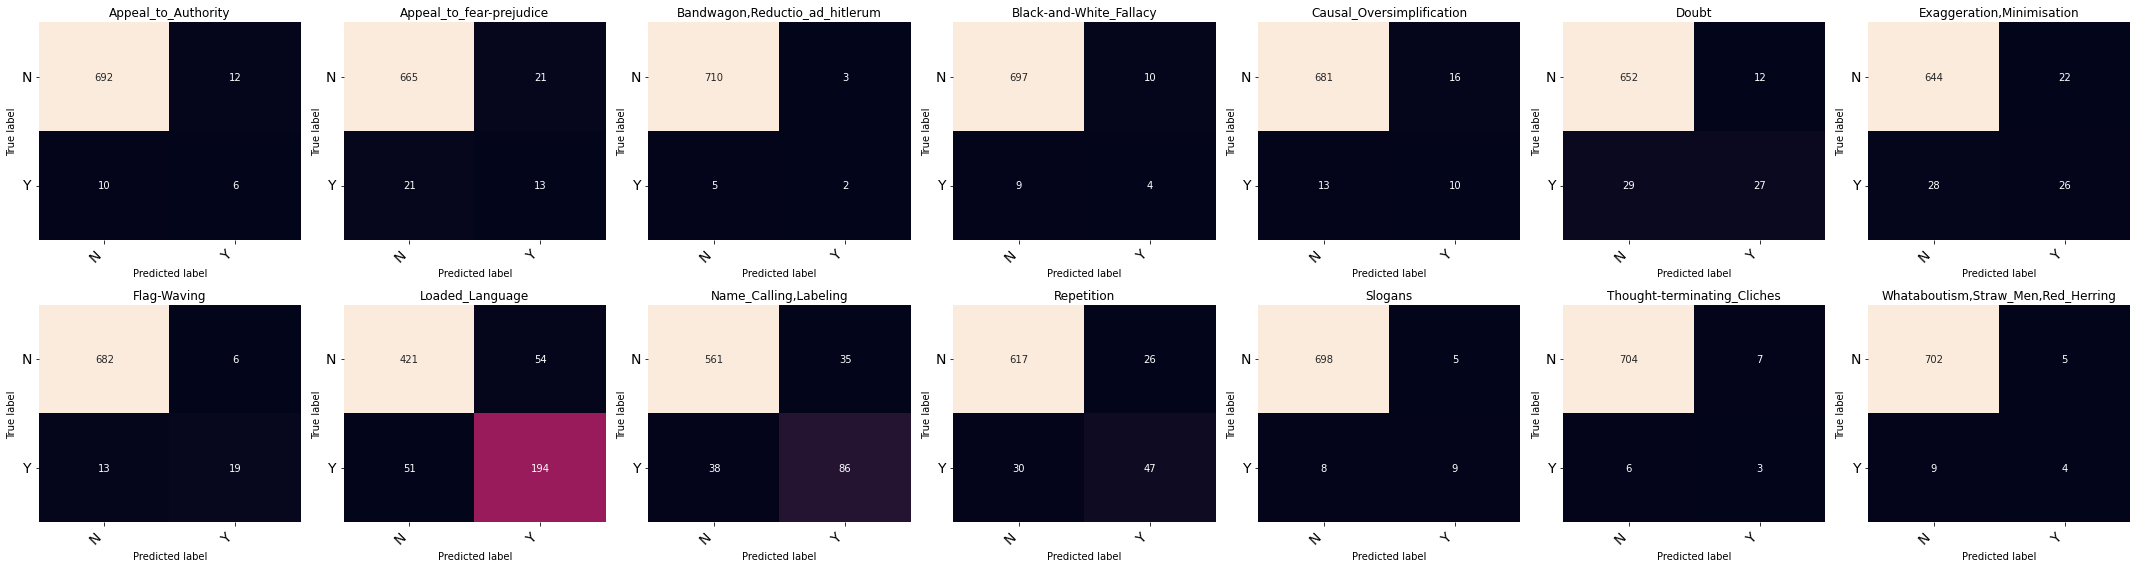

In [ ]:
#@title Get confusion matrices
gold_list = targets
preds_list = outputs

target_names = [
      'Appeal_to_Authority',
      'Appeal_to_fear-prejudice',
      'Bandwagon,Reductio_ad_hitlerum',
      'Black-and-White_Fallacy',
      'Causal_Oversimplification',
      'Doubt',
      'Exaggeration,Minimisation',
      'Flag-Waving',
      'Loaded_Language',
      'Name_Calling,Labeling',
      'Repetition',
      'Slogans',
      'Thought-terminating_Cliches',
      'Whataboutism,Straw_Men,Red_Herring']


report = metrics.classification_report(gold_list, preds_list, target_names=target_names,zero_division=0,digits=4)
cm = metrics.multilabel_confusion_matrix(gold_list, preds_list)
accuracy = metrics.accuracy_score(gold_list, preds_list)
print("model name: ",config['MODEL_ID'], '\nArabert_Prep:',config['ArabertPreprocessor'],"\nAccuracy: ", accuracy)

print()
print(report)

fig, ax = plt.subplots(2, 7, figsize=(30, 8))
for axes, cmi, label in zip(ax.flatten(), cm, target_names):
    print_confusion_matrix(cmi, axes, label, ["N", "Y"])
fig.tight_layout()
plt.show()
fig.savefig(config['PATH']+"confusion_matrices.png")

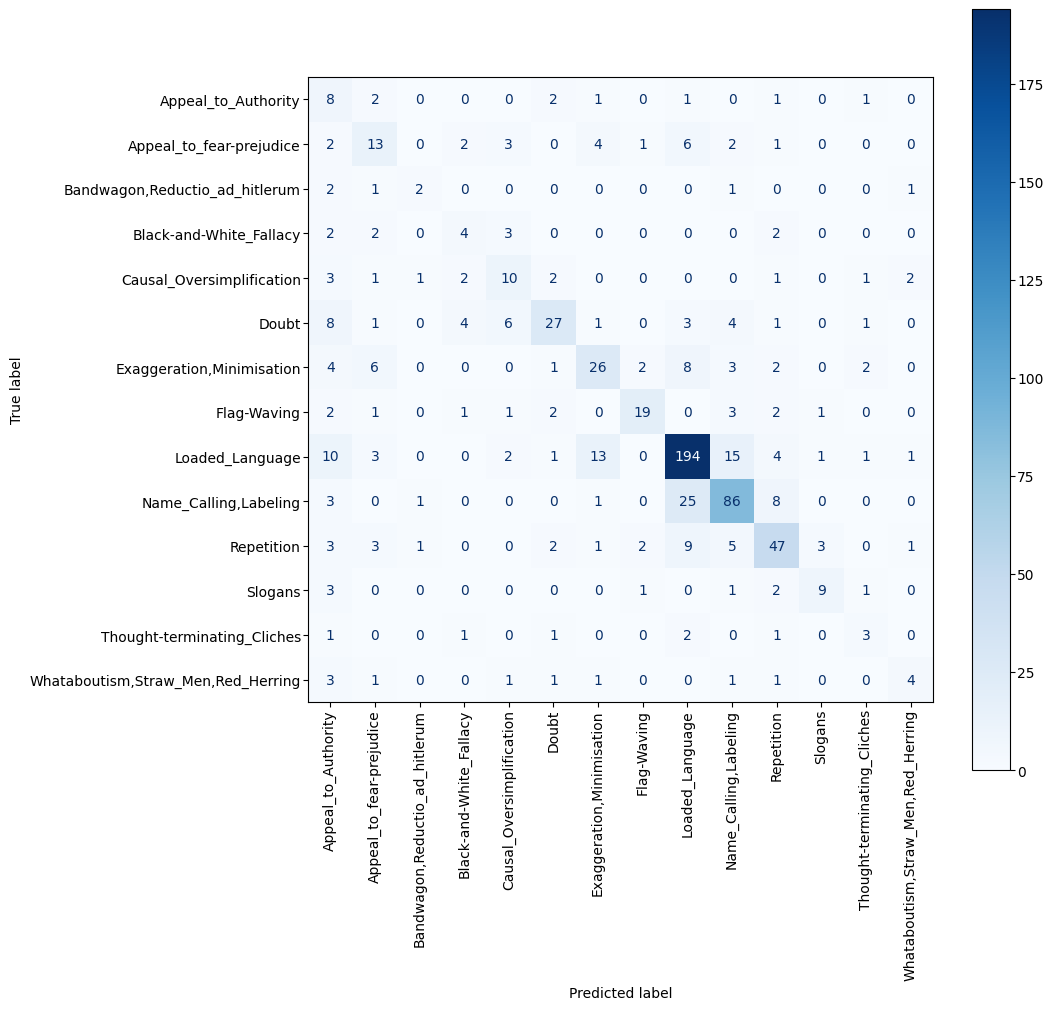

In [ ]:
#@title Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

preds_list = [[int(i) for i in row] for row in preds_list]

preds_list = [i.index(max(i)) for i in preds_list]
gold_list = [i.index(max(i)) for i in gold_list]

cm = confusion_matrix(gold_list, preds_list)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels = target_names)
fig, ax = plt.subplots(figsize = (30,30))
disp.plot(ax=ax,)
plt.Figure.dpi = 250
plt.xticks(rotation=90)
plt.show()

# English Model training

## Utility

In [ ]:
def TrainEnglishModel(train, valid, text_col_name):
  """
  Main runner code to finetune model. Saves model weights on each epoch if the 
  model score is higher than before.
  """
  target_names = [
      'Appeal_to_Authority',
      'Appeal_to_fear-prejudice',
      'Bandwagon,Reductio_ad_hitlerum',
      'Black-and-White_Fallacy',
      'Causal_Oversimplification',
      'Doubt',
      'Exaggeration,Minimisation',
      'Flag-Waving',
      'Loaded_Language',
      'Name_Calling,Labeling',
      'Repetition',
      'Slogans',
      'Thought-terminating_Cliches',
      'Whataboutism,Straw_Men,Red_Herring']
  train = MapLabels(train)
  valid = MapLabels(valid)

  train = train.sample(frac=1).reset_index(drop=True)

  train_dataset = Dataset(
      text=train[text_col_name].values,
      target=train['onehot'].values,
      tokenizer = TOKENIZER
  )

  train_data_loader = DataLoader(
      train_dataset, batch_size=config['TRAIN_BATCH_SIZE'], num_workers=2
  )

  valid_dataset = Dataset(
      text=valid[text_col_name].values,
      target=valid['onehot'].values,
      tokenizer = TOKENIZER
  )

  valid_data_loader = DataLoader(
      valid_dataset, batch_size=config['VALID_BATCH_SIZE'], num_workers=1
  )

  device = torch.device(config['DEVICE'])
  model = Model()
  model.to(device)

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.001,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0,
      },
  ]

  num_train_steps = int(len(train) / config['TRAIN_BATCH_SIZE'] * config['EPOCHS'])
  optimizer = AdamW(optimizer_parameters, lr=config['LEARNING_RATE'])
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
  )

  best_score = 0
  last_best_epoch = 0
  performance = []
  for epoch in range(config['EPOCHS']):
    train_fn(train_data_loader, model, optimizer, device, scheduler)
    outputs, targets = eval_fn(valid_data_loader, model, device)
    outputs = np.array(outputs) >= 0.5
    f1_samples = metrics.f1_score(targets, outputs,average='samples')
    f1_micro = metrics.f1_score(targets, outputs,average='micro')
    f1_macro = metrics.f1_score(targets, outputs,average='macro')
    accuracy = metrics.accuracy_score(targets, outputs)
    print(f"<---------------Epoch {epoch+1}--------------->")
    print(f"f1-Samples Score = {f1_samples}")
    print(f"f1-Micro Score = {f1_micro}")
    print(f"f1-Macro Score = {f1_macro}")
    print(f"Accuracy Score = {accuracy}")
    epoch_performance = {'Epoch': epoch,
                         'F1-Samples':f1_samples,
                         'F1-Micro':f1_micro,
                         'F1-Macro':f1_macro,
                         'Accuracy':accuracy}
    performance.append(epoch_performance)
    if f1_micro > best_score:
      last_best_epoch = epoch+1
      print("Saving model...")
      torch.save(model.state_dict(), config['PATH']+"model.bin")
      report = report = metrics.classification_report(targets,outputs,target_names=target_names, zero_division=0, digits=4)
      best_score = f1_micro
  
  print(report)
  del model
  return performance, last_best_epoch

## Training

### Config

In [ ]:
config = {
    'MODEL_ID': "bert-base-cased",
    'HIDDEN_SIZE': 768,
    'DEVICE': "cuda",
    'MAX_LEN': 200,

    'TRAIN_BATCH_SIZE': 32,
    'VALID_BATCH_SIZE': 16,
    'TRAIN_VALID_TEST_SPLIT':(0.8, 0.1, 0.1), # train-valid-test: 0.8-0.1-0.1

    'PATIENCE':3, #for tuning.

    'EPOCHS': 15,
    'LEARNING_RATE': 1e-5,

    'PATH': "/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Transformers/",
    'NUM_LABELS': 14,
  }
performance = {}
TOKENIZER = transformers.BertTokenizer.from_pretrained(config['MODEL_ID'])

In [ ]:
path = r'/content/JUST-Arabic-Propaganda/data/Translated Data/'
train = pd.read_csv(path+'train.csv')
valid = pd.read_csv(path+'valid.csv')
test = pd.read_csv(path+'test.csv')

In [ ]:
train

id  ...                                             Arabic
0     706088110  ...                             الأجانب غير القانونيين
1     787085939  ...                                              بائسة
2     776049384  ...                                        الاستبدادية
3     776385494  ...   أسلحة بلاستيكية لا يمكن تعقبها، لا يمكن اكتشافها
4     111111135  ...  كان اليهود «مسؤولين عن كل هذا السلوك القذارة و...
...         ...  ...                                                ...
5747  778664280  ...      توقف عن إذلال نفسها عن طريق الانحناء لاستيعاب
5748  778139122  ...    في عالم حقوق الإنسان، الصمت يساوي القتل الجماعي
5749  999000158  ...                                    نعم، صحيح، حكيم
5750  790266787  ...                                  «يعني في حالة سكر
5751  721406153  ...                                              مجنون

[5752 rows x 4 columns]

### Training Code

In [ ]:
model_performance = TrainEnglishModel(train, valid, text_col_name='text_span')
performance['MODEL_EPOCHS'] , performance['LAST_BEST_EPOCH'] = model_performance

with open(config['PATH']+'config.json', 'w') as fp:
    json.dump(config, fp)
with open(config['PATH']+'Epochs.json', 'w') as fp:
    json.dump(performance, fp)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Samples Score = 0.0
f1-Micro Score = 0.0
f1-Macro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Samples Score = 0.32684283727399166
f1-Micro Score = 0.45808966861598444
f1-Macro Score = 0.09071411588309793
Accuracy Score = 0.32684283727399166
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Samples Score = 0.3963838664812239
f1-Micro Score = 0.5317164179104478
f1-Macro Score = 0.11281086546501003
Accuracy Score = 0.3963838664812239
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Samples Score = 0.4575799721835883
f1-Micro Score = 0.5859305431878895
f1-Macro Score = 0.1794253448335081
Accuracy Score = 0.4575799721835883
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Samples Score = 0.48817802503477054
f1-Micro Score = 0.6015424164524421
f1-Macro Score = 0.21071181708463854
Accuracy Score = 0.48817802503477054
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Samples Score = 0.5285118219749653
f1-Micro Score = 0.6224406224406225
f1-Macro Score = 0.26260723662229835
Accuracy Score = 0.5285118219749653
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Samples Score = 0.5382475660639777
f1-Micro Score = 0.6257073565076798
f1-Macro Score = 0.27586260828452996
Accuracy Score = 0.5382475660639777
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Samples Score = 0.5521557719054242
f1-Micro Score = 0.6321656050955414
f1-Macro Score = 0.2826838458984185
Accuracy Score = 0.5521557719054242
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Samples Score = 0.5535465924895688
f1-Micro Score = 0.6277602523659306
f1-Macro Score = 0.28552941493193945
Accuracy Score = 0.5535465924895688


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 10--------------->
f1-Samples Score = 0.5618915159944368
f1-Micro Score = 0.6332288401253919
f1-Macro Score = 0.29503992914019594
Accuracy Score = 0.5618915159944368
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 11--------------->
f1-Samples Score = 0.5605006954102921
f1-Micro Score = 0.6287051482059283
f1-Macro Score = 0.3139212634273612
Accuracy Score = 0.5605006954102921


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 12--------------->
f1-Samples Score = 0.5716272600834492
f1-Micro Score = 0.6372093023255815
f1-Macro Score = 0.3293256018276187
Accuracy Score = 0.5716272600834492
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 13--------------->
f1-Samples Score = 0.5841446453407511
f1-Micro Score = 0.6456571867794005
f1-Macro Score = 0.3553045244002991
Accuracy Score = 0.5841446453407511
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 14--------------->
f1-Samples Score = 0.5924895688456189
f1-Micro Score = 0.6528735632183907
f1-Macro Score = 0.36429773269445
Accuracy Score = 0.5924895688456189
Saving model...


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

<---------------Epoch 15--------------->
f1-Samples Score = 0.5924895688456189
f1-Micro Score = 0.6523736600306278
f1-Macro Score = 0.3652219921151456
Accuracy Score = 0.5924895688456189
                                    precision    recall  f1-score   support

               Appeal_to_Authority     0.0000    0.0000    0.0000        16
          Appeal_to_fear-prejudice     0.5263    0.2941    0.3774        34
    Bandwagon,Reductio_ad_hitlerum     0.0000    0.0000    0.0000         8
           Black-and-White_Fallacy     0.0000    0.0000    0.0000        13
         Causal_Oversimplification     1.0000    0.0909    0.1667        22
                             Doubt     0.5741    0.5536    0.5636        56
         Exaggeration,Minimisation     0.5000    0.5660    0.5310        53
                       Flag-Waving     0.6552    0.6129    0.6333        31
                   Loaded_Language     0.8043    0.7551    0.7789       245
             Name_Calling,Labeling     0.8261    0.7

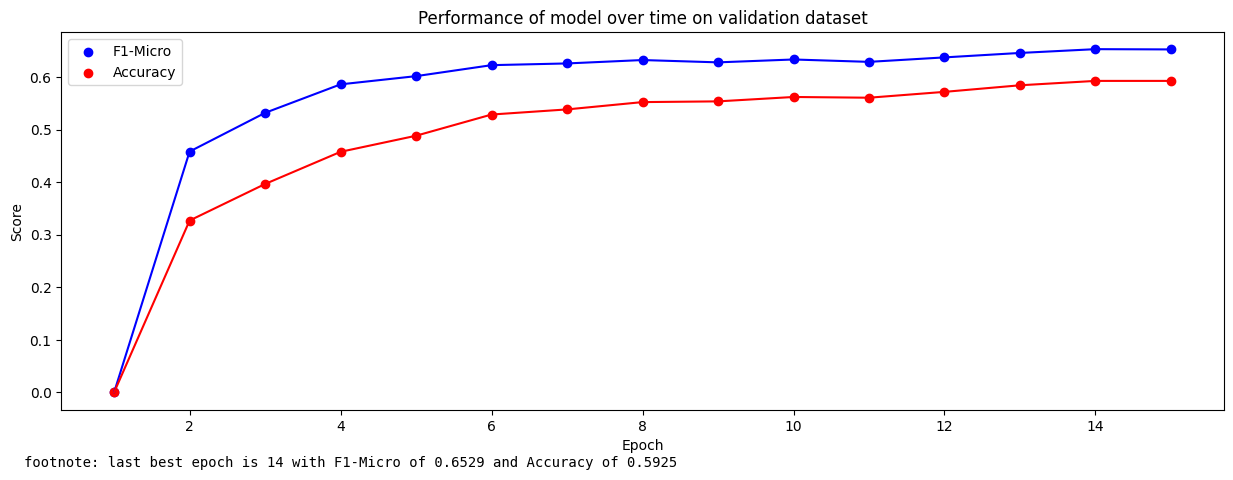

In [ ]:
path = config['PATH']+"performance.png"
plot_performance(performance, path)

## Testing

In [ ]:
#@title Test model on the test dataset
test = MapLabels(test)

model = Model()
model.load_state_dict(torch.load(config['PATH']+"model.bin"))
model.eval()
device = torch.device(config['DEVICE'])
model.to(device)

test_dataset = Dataset(
      text=test['Arabic'].values,
      target=test['onehot'].values,
      tokenizer = TOKENIZER
  )

test_data_loader = DataLoader(
    test_dataset, batch_size=1, num_workers=1
)
outputs, targets = eval_fn(test_data_loader, model, device)
outputs = np.array(outputs) >= 0.5
f1 = metrics.f1_score(targets, outputs,average='samples')
f1_micro = metrics.f1_score(targets, outputs,average='micro')
f1_macro = metrics.f1_score(targets, outputs,average='macro')
accuracy = metrics.accuracy_score(targets, outputs)
print(f"<---------------Test Set Performance--------------->")
print(f"f1-Samples Score = {f1}")
print(f"f1-Micro Score = {f1_micro}")
print(f"f1-Macro Score = {f1_macro}")
print(f"Accuracy Score = {accuracy}")

  0%|          | 0/720 [00:00<?, ?it/s]

<---------------Test Set Performance--------------->
f1-Samples Score = 0.2722222222222222
f1-Micro Score = 0.3166397415185783
f1-Macro Score = 0.0649275926865061
Accuracy Score = 0.2722222222222222


model name:  bert-base-cased 
Accuracy:  0.2722222222222222

                                    precision    recall  f1-score   support

               Appeal_to_Authority     0.0000    0.0000    0.0000        16
          Appeal_to_fear-prejudice     0.0000    0.0000    0.0000        34
    Bandwagon,Reductio_ad_hitlerum     0.0000    0.0000    0.0000         7
           Black-and-White_Fallacy     0.0000    0.0000    0.0000        13
         Causal_Oversimplification     0.0000    0.0000    0.0000        23
                             Doubt     0.0000    0.0000    0.0000        56
         Exaggeration,Minimisation     0.0000    0.0000    0.0000        54
                       Flag-Waving     0.0000    0.0000    0.0000        32
                   Loaded_Language     0.4024    0.6816    0.5061       245
             Name_Calling,Labeling     0.3059    0.2097    0.2488       124
                        Repetition     0.1250    0.0260    0.0430        77
                          

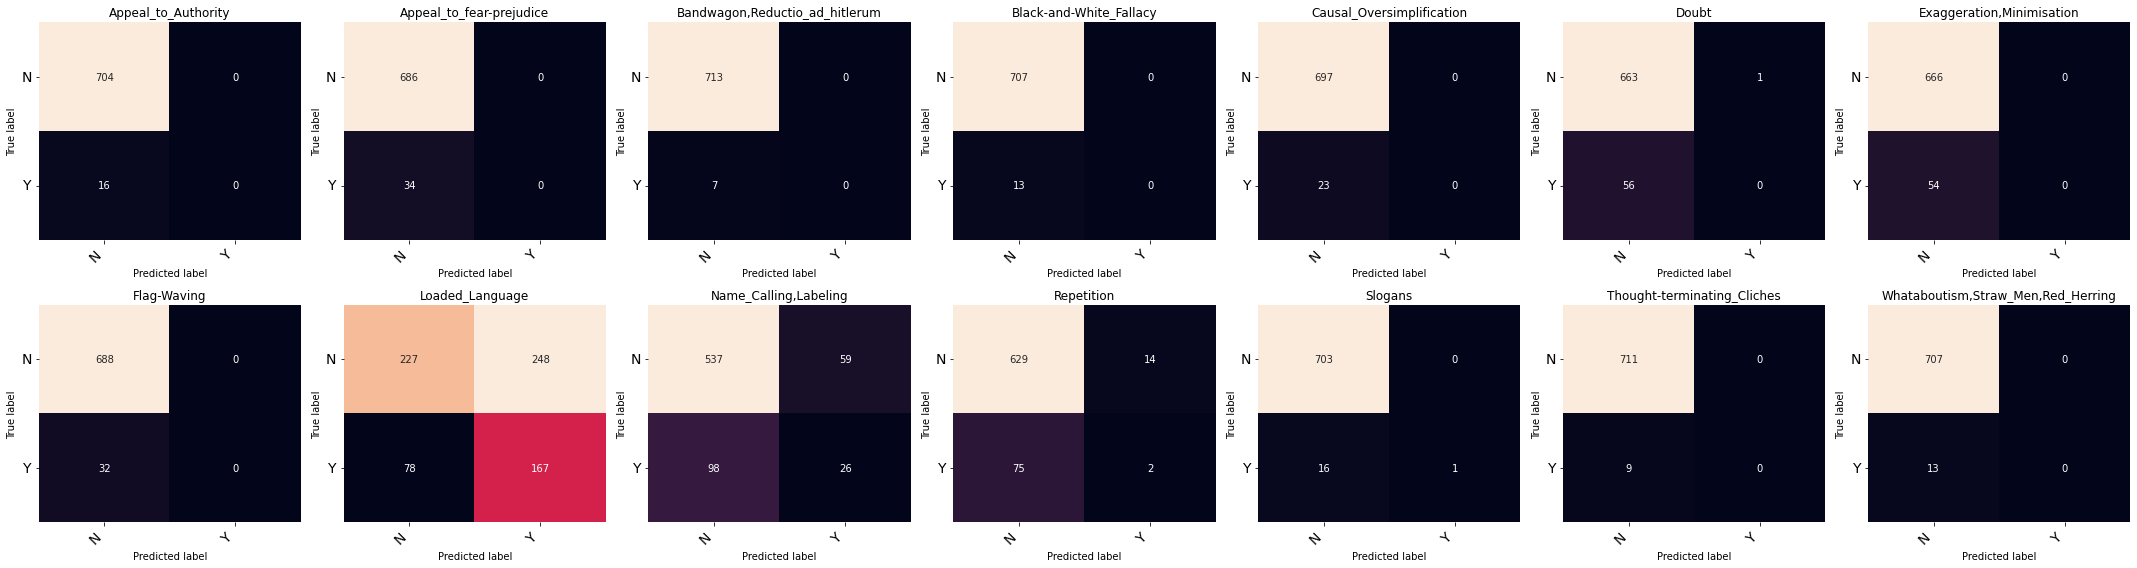

In [ ]:
#@title Get confusion matrices
gold_list = targets
preds_list = outputs

target_names = [
      'Appeal_to_Authority',
      'Appeal_to_fear-prejudice',
      'Bandwagon,Reductio_ad_hitlerum',
      'Black-and-White_Fallacy',
      'Causal_Oversimplification',
      'Doubt',
      'Exaggeration,Minimisation',
      'Flag-Waving',
      'Loaded_Language',
      'Name_Calling,Labeling',
      'Repetition',
      'Slogans',
      'Thought-terminating_Cliches',
      'Whataboutism,Straw_Men,Red_Herring']


report = metrics.classification_report(gold_list, preds_list, target_names=target_names,zero_division=0,digits=4)
cm = metrics.multilabel_confusion_matrix(gold_list, preds_list)
accuracy = metrics.accuracy_score(gold_list, preds_list)
print("model name: ",config['MODEL_ID'], "\nAccuracy: ", accuracy)

print()
print(report)

fig, ax = plt.subplots(2, 7, figsize=(30, 8))
for axes, cmi, label in zip(ax.flatten(), cm, target_names):
    print_confusion_matrix(cmi, axes, label, ["N", "Y"])
fig.tight_layout()
plt.show()
fig.savefig(config['PATH']+"confusion_matrices.png")

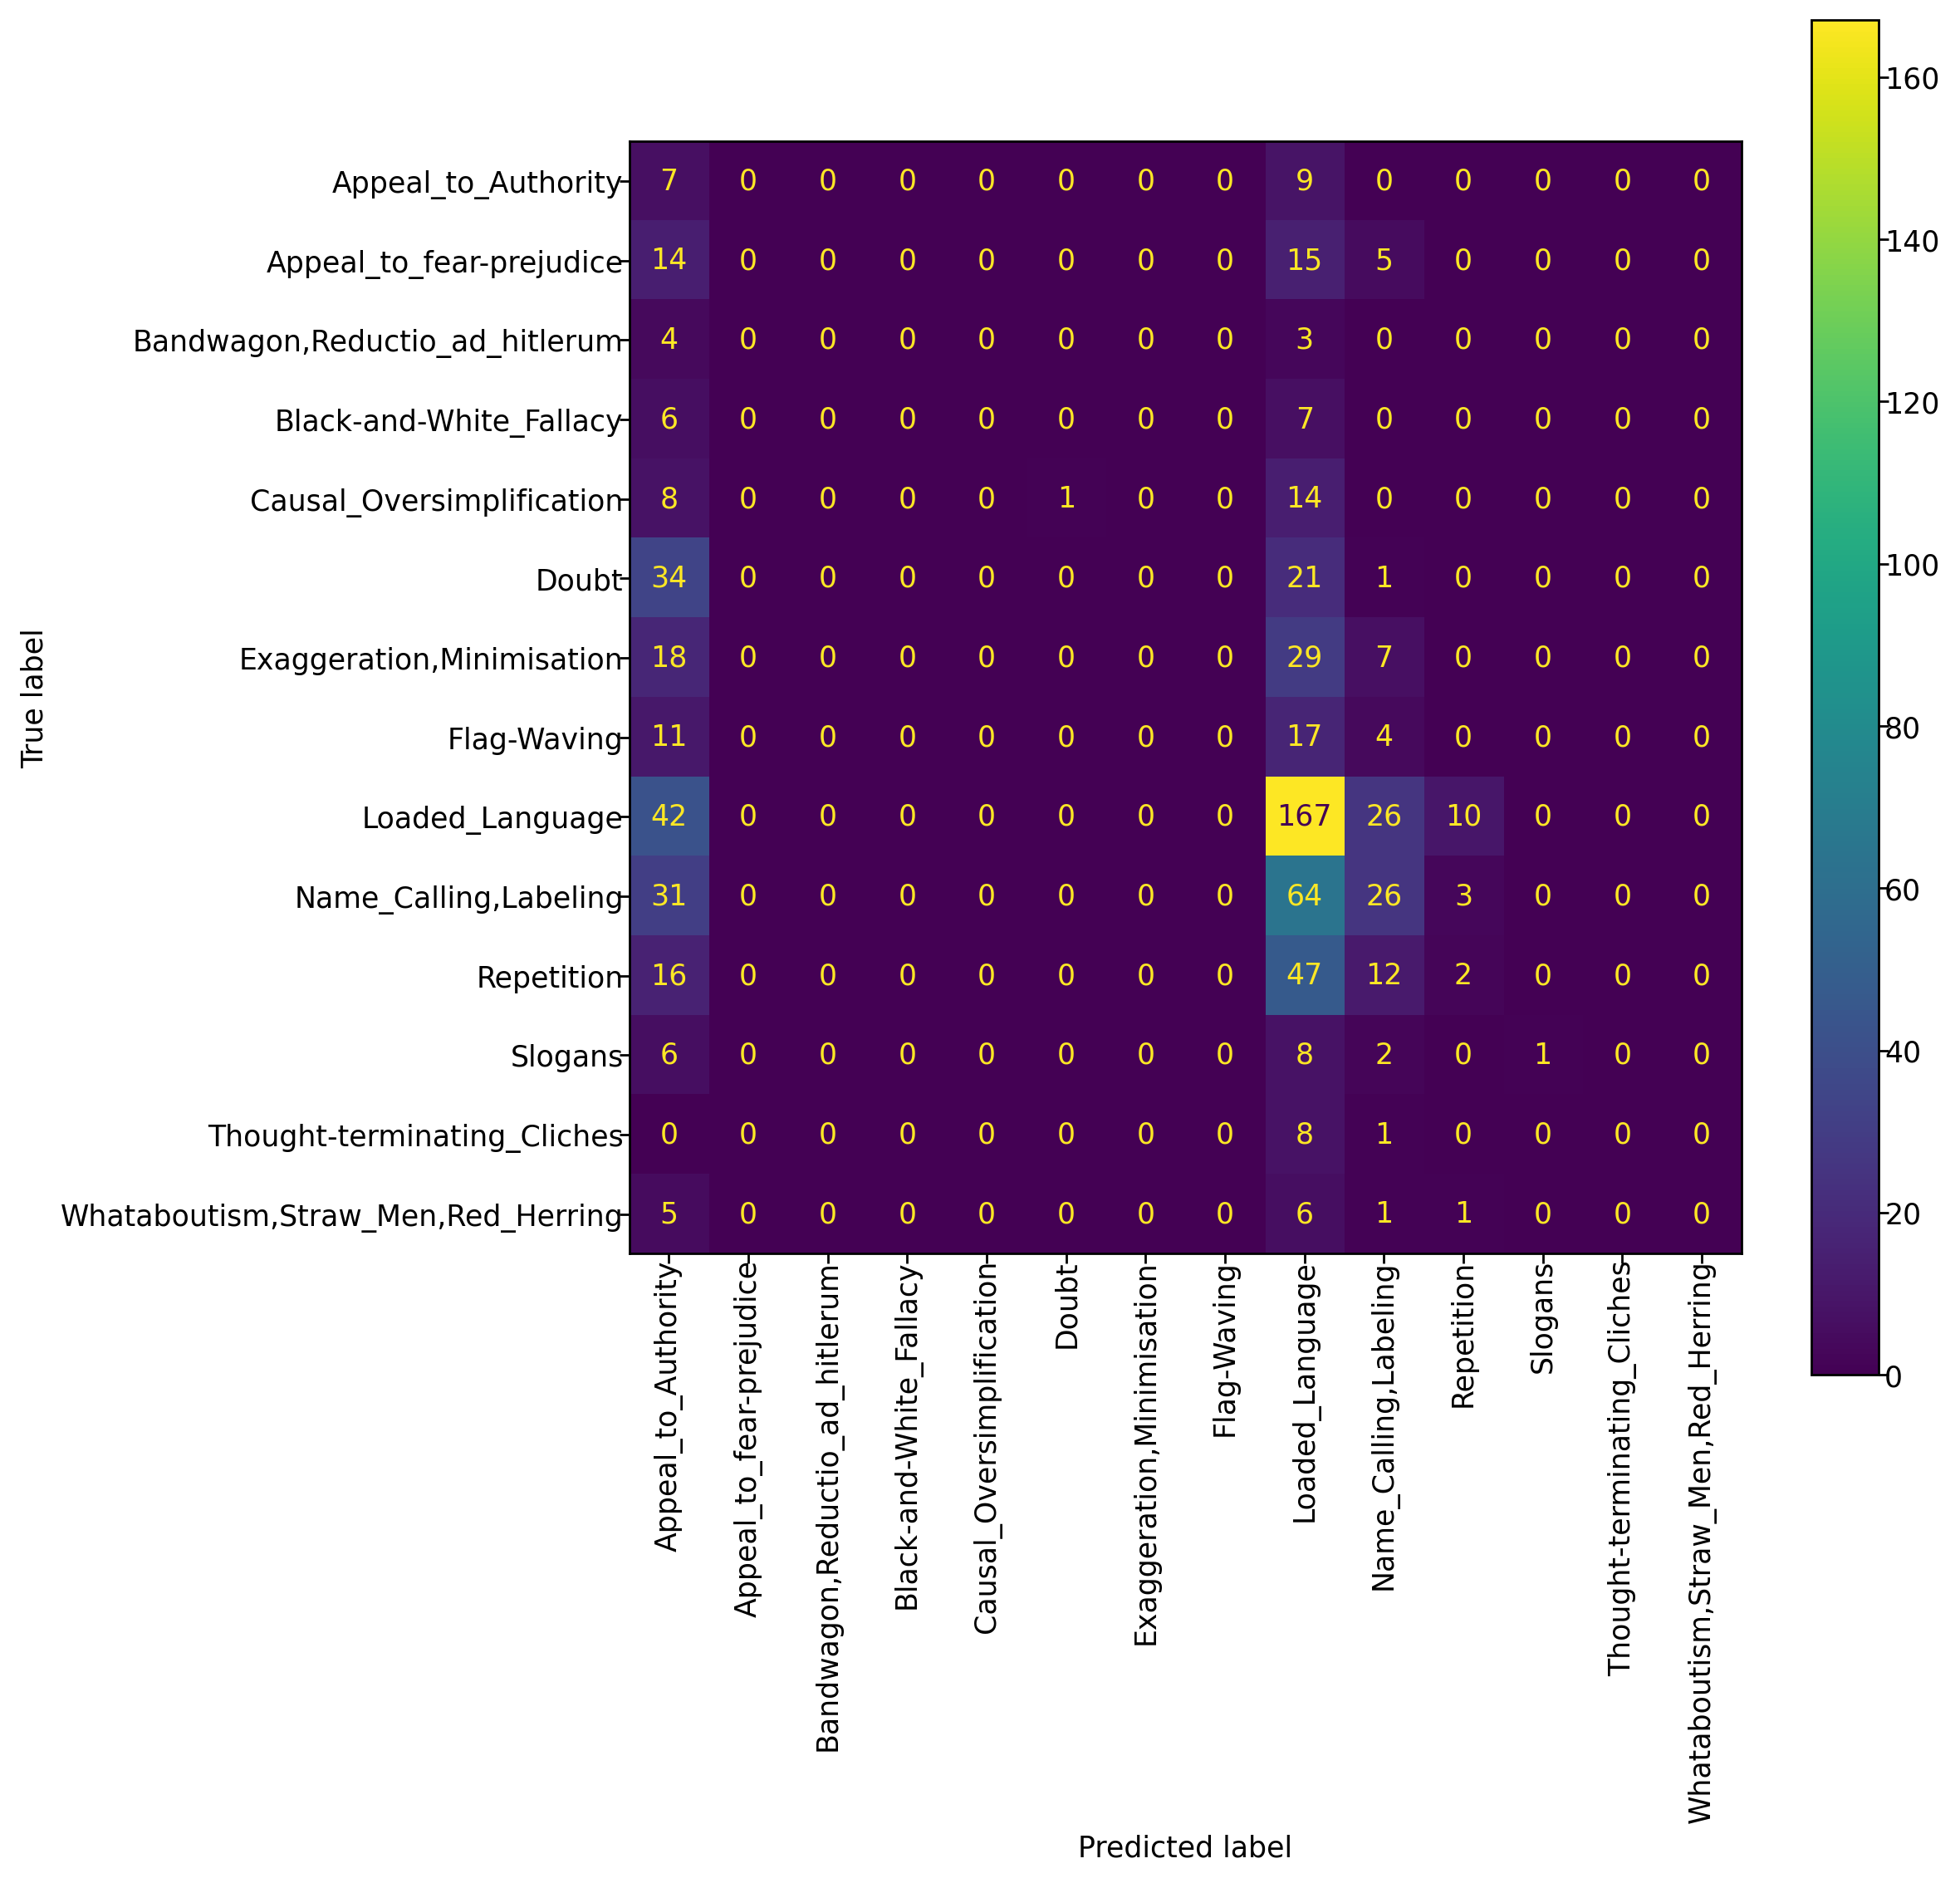

In [ ]:
#@title Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

preds_list = [[int(i) for i in row] for row in preds_list]

preds_list = [i.index(max(i)) for i in preds_list]
gold_list = [i.index(max(i)) for i in gold_list]

cm = confusion_matrix(gold_list, preds_list)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels = target_names)
fig, ax = plt.subplots(figsize = (30,30))
disp.plot(ax=ax,)
plt.Figure.dpi = 250
plt.xticks(rotation=90)
plt.show()